In [1]:
%load_ext autoreload
%autoreload 2

## AGN Photo Error Metric
This metric examines the photometric measurement error of a point-like source with a particular magnitude when observred arcoss the WFD survey. Obviously the error depending on many factors and will vary from visit to visit. So we use the mean of the computed errors across the 10-year survey to summarize the photometric error at a particular point on the sky, and certainly other statistics can be easier subtituted if one want. The photometric measurement error is computed using equation \#5 from the [LSST Overview paper](http://arxiv.org/abs/0805.2366) with the $\gamma$ value obtained from table \#2 in the same paper.

The notebook shows how to compute the photometric mesaurement error from the 5-$\sigma$ depth given by the opsim for each visit using a stacker and use the `MeanMetric` to summarize across 10 years at each healpix bin.

### 0. Software Setup

In [1]:
your_username = 'ywx649999311'

In [2]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [3]:
# import custom stacker from script
from AGNStacker import MagErrStacker

# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

### 1. Define `MagErr` Stacker
Note that custom stacker will be only be registered if imported from a script, otherwise we can't find it and will not be run metrics on new columns added by custom stackers. In addition, the script __MUST__ be imported before the $\texttt{lsst.sims.maf.metrics}$ module get imported.

In [4]:
MagErrStacker??

Init signature: MagErrStacker(magnitude=20, m5Col='fiveSigmaDepth', filterCol='filter')
Source:        
class MagErrStacker(BaseStacker):
    """
    Calculate the Photometric error given the brightness of an object in magnitude. 
    
    
    The photometric error is obtained using eqn #4 and #5 from the overview paper with 
    the gamma values provided by table #2 in the same paper.
    
    Parameters
    ----------
    magnitude: float
        Magnitude at which the photometric error to be computed. Default 20
    m5Col: str, opt
        Name of the 5-sigma depth column. Default fiveSigmaDepth
    filterCol: str, opt
        Name the filter column. Default filter
    """
    colsAdded = ['magErr']
    
    # see eqn #4 & #5 in overview paper
    gamma = {'u': 0.038, 'g':0.039, 'r':0.039, 'i':0.039, 'z':0.039, 'y':0.039}
    sigmaSys = {'u':0.0075, 'g':0.005, 'r':0.005, 'i':0.005, 'z':0.0075, 'y':0.0075}
    
    def __init__(self, magnitude=20, m5Col = 'fiveSigmaDepth', filterCol

In [9]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = '../tmp/PhotoMetric/ResultDBs/'
metricDataPath = '../tmp/PhotoMetric/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

In [10]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [11]:
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

### 2. Test the Stacker \& Explore Metric

In [13]:
ddfInfo(opSimDbs[dbRuns[11]], 'COSMOS')

{'proposalId': 2, 'Coord': (150.11, 2.14)}

In [14]:
passmetric = metrics.PassMetric(cols=['fiveSigmaDepth', 'magErr'])
slicer = slicers.UserPointsSlicer(ra=[150.11], dec=[2.14])
constraint = 'filter = "g"'

testBundle = metricBundles.MetricBundle(passmetric, slicer, constraint, \
                                        stackerList=[MagErrStacker(22)])

In [15]:
testBDict = {'passMagErr': testBundle}
mg = metricBundles.MetricBundleGroup(testBDict, opSimDbs[dbRuns[11]], \
                                     outDir=outDir, resultsDb=resultDbs[dbRuns[11]])
mg.runAll()

Querying database SummaryAllProps with constraint filter = "g" for columns ['fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec']
Found 223719 visits
Running:  ['passMagErr']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [16]:
data = testBundle.metricValues.data[0]
testBundle.metricValues.data[0][:10]

array([(150.53265103, 24.78181564, 'g', 0.58451906, 0.01828128),
       (150.2962158 , 25.02181374, 'g', 0.64709656, 0.01536188),
       (151.59887378, 24.09611117, 'g', 1.6947212 , 0.03147612),
       (151.38123143, 24.85519022, 'g', 1.46606772, 0.01731547),
       (151.37268938, 24.26715751, 'g', 1.53860471, 0.02734588),
       (151.664559  , 24.61930734, 'g', 1.90766464, 0.02067963),
       (151.68104016, 24.37217015, 'g', 1.42869167, 0.02512054),
       (151.67368528, 24.01311399, 'g', 1.64537975, 0.0337319 ),
       (151.64230586, 24.45188276, 'g', 1.6279373 , 0.02357281),
       (151.65114882, 24.668408  , 'g', 1.81377542, 0.01991517)],
      dtype=[('fieldRA', '<f8'), ('fiveSigmaDepth', '<f8'), ('filter', '<U256'), ('fieldDec', '<f8'), ('magErr', '<f8')])

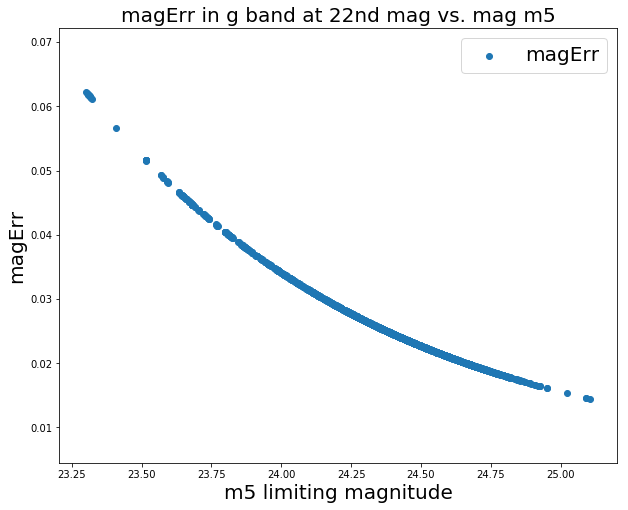

In [17]:
fig = plt.figure(figsize=(10,8))
g_data = data[data['filter'] == 'g']
plt.scatter(g_data['fiveSigmaDepth'], g_data['magErr'], label='magErr')
plt.title('magErr in g band at 22nd mag vs. mag m5', fontsize=20)
plt.xlabel('m5 limiting magnitude', fontsize=20)
plt.ylabel('magErr', fontsize=20)
plt.legend(fontsize=20)

Text(0, 0.5, 'Counts')

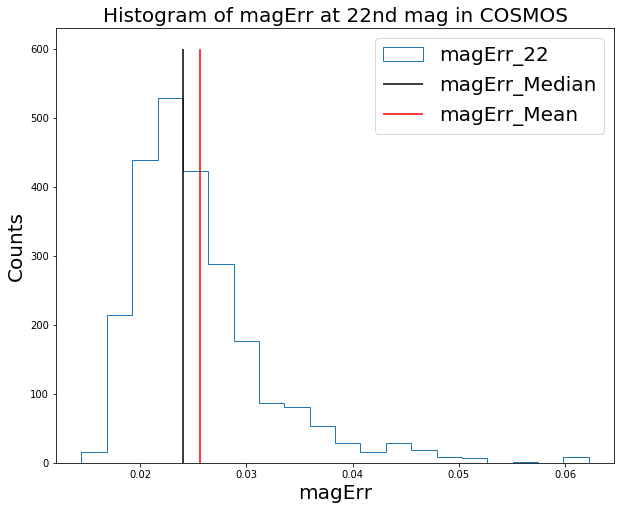

In [19]:
fig = plt.figure(figsize=(10,8))
_ = plt.hist(g_data['magErr'],bins=20, histtype='step', label='magErr_22')
_ = plt.vlines(x=np.median(g_data['magErr']), ymin=0, ymax=600, label='magErr_Median')
_ = plt.vlines(x=np.mean(g_data['magErr']), ymin=0, ymax=600, colors='r', label='magErr_Mean')
plt.legend(fontsize=20)
plt.title('Histogram of magErr at 22nd mag in COSMOS', fontsize=20)
plt.xlabel('magErr', fontsize=20)
plt.ylabel('Counts', fontsize=20)

We can see the mean is larger than the median. Since the power of a white noise process is just the variance of the noise, thus it doesn't hurt to assume a higher level of noise power, thus we will use the mean statistic to summarize the photometric error for all visits at a particular point on the sky. 

### 3. Declare some metrics to run on above OpSims

In [20]:
# nVisit Metric in U band
magErrMean = metrics.MeanMetric(col='magErr', metricName='uMagErrMean_23')
magErrSlicer = slicers.HealpixSlicer(nside=64)
uMagErrConstraint = 'filter = "u"'
uMagErrConstraint += ' and note not like "DD%"'
uMagErrConstraint += ' and proposalId = 1'

uMagErr = metricBundles.MetricBundle(magErrMean, magErrSlicer, \
                uMagErrConstraint, stackerList=[MagErrStacker(23)])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [21]:
# nVisit Metric in U banda
magErrMean = metrics.MeanMetric(col='magErr', metricName='gMagErrMean_23')
magErrSlicer = slicers.HealpixSlicer(nside=64)
gMagErrConstraint = 'filter = "g"'
gMagErrConstraint += ' and note not like "DD%"'
gMagErrConstraint += ' and proposalId = 1'

gMagErr = metricBundles.MetricBundle(magErrMean, magErrSlicer, \
                gMagErrConstraint, stackerList=[MagErrStacker(23)])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [22]:
# set summary statistics
summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
uMagErr.setSummaryMetrics(summaryMetrics)
gMagErr.setSummaryMetrics(summaryMetrics)

In [23]:
# create a bundleDict for all metrics to run on each opSim
bundleDict = {'uMagErrMetric': uMagErr, 'gMagErrMetric': gMagErr}

### 4. Loop over all OpSims in dbDir and run MAF
While constructing a metricBundleGroup from a dictionary (the cell below), you will need to provide the path to a directory (`metricDataPath` in the cell below) where you would like to store the metric data (this is **DIFFERENT** than path to the metric data, `outDir`). To construct metricbundles for plotting and further analysis, this path will be needed.

In [24]:
# below I am only going to run metrics on the first five opsims
for run in dbRuns[0:5]:
    # must set run name for each opSim to store metric data into
    # separate files
    print(f'Running metrics on: {run}')
    print('*************************************')
    uMagErr.setRunName(run)
    gMagErr.setRunName(run)
    metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
                    opSimDbs[run], metricDataPath, resultDbs[run], verbose=False)
    metricGroup.runAll()

Running metrics on: dcr_nham1_ugri_v1.5_10yrs
*************************************
Running metrics on: rolling_mod6_sdf_0.20_v1.5_10yrs
*************************************
Running metrics on: wfd_depth_scale0.95_noddf_v1.5_10yrs
*************************************
Running metrics on: u60_v1.5_10yrs
*************************************
Running metrics on: footprint_stuck_rollingv1.5_10yrs
*************************************


### 5. Now Visualize Summary Stat

In [27]:
# show avaiable summary
getSummaryStatNames(resultDbs[dbRuns[0]], 'uMagErrMean_23')

[{'metricId': 1, 'StatNames': ['Mean', 'Median', 'Rms']}]

#### 5.1 Summary statistics for `uMagErrMean_23`

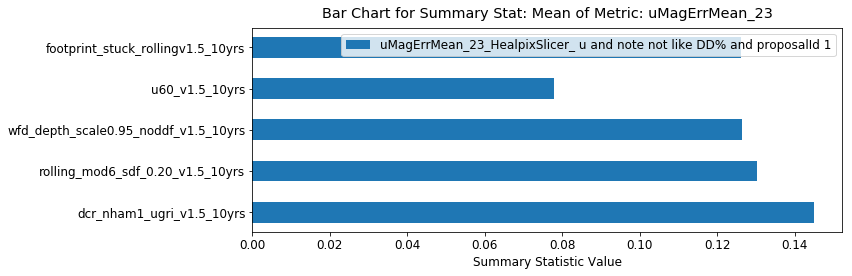

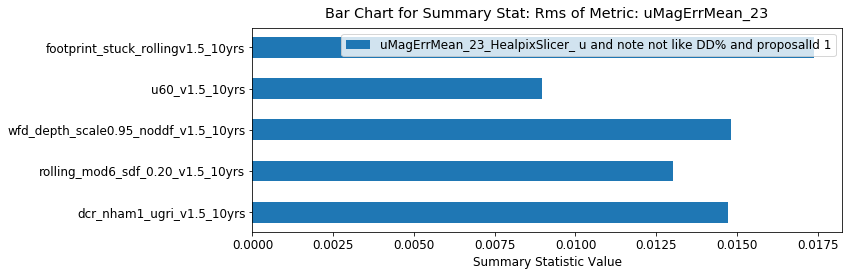

In [28]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'uMagErrMean_23', 'Mean', runNames=dbRuns[0:5])

# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'uMagErrMean_23', 'Rms', runNames=dbRuns[0:5])

#### 5.2 Summary statistics for `gMagErrMean_23`

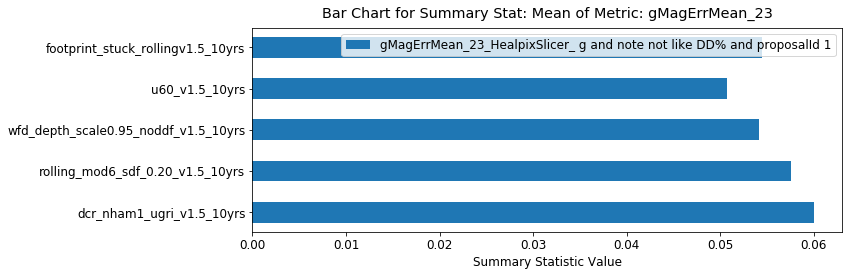

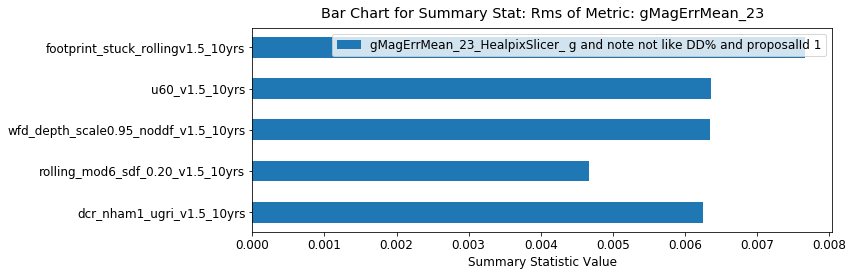

In [29]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'gMagErrMean_23', 'Mean', runNames=dbRuns[0:5])

# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'gMagErrMean_23', 'Rms', runNames=dbRuns[0:5])

### 6. Look at the distribution `gMagErrMean_23` over the Sky and a histogram

In [30]:
get_metricMetadata(resultDbs[dbRuns[0]])

,metricId,metricName,slicerName,sqlConstraint,metricMetadata,metricDataFile
0,1,uMagErrMean_23,HealpixSlicer,"filter = ""u"" and note not like ""DD%"" and propo...",u and note not like DD% and proposalId 1,dcr_nham1_ugri_v1_5_10yrs_uMagErrMean_23_u_and...
1,2,gMagErrMean_23,HealpixSlicer,"filter = ""g"" and note not like ""DD%"" and propo...",g and note not like DD% and proposalId 1,dcr_nham1_ugri_v1_5_10yrs_gMagErrMean_23_g_and...


In [31]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts = {}

for runName in dbRuns[0:5]:
    bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


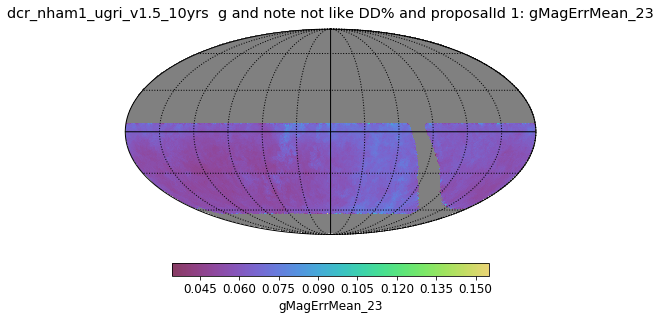

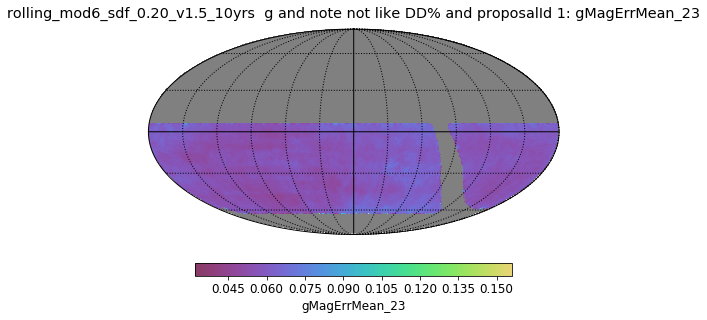

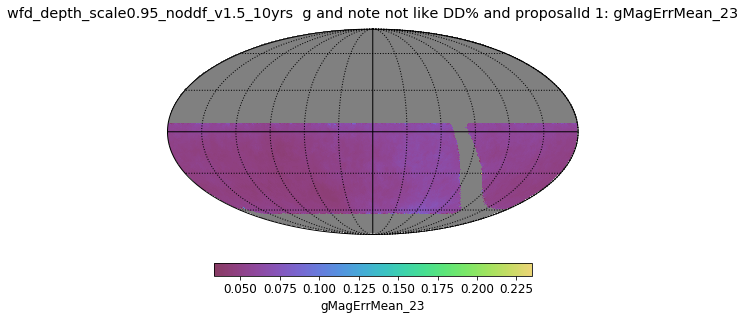

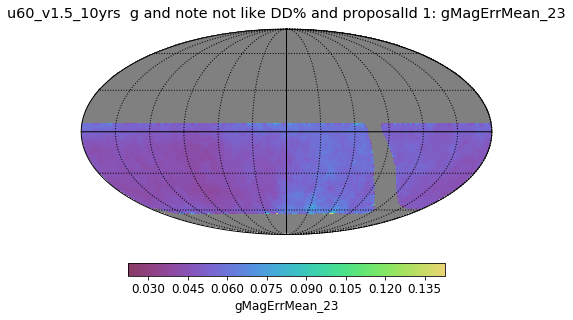

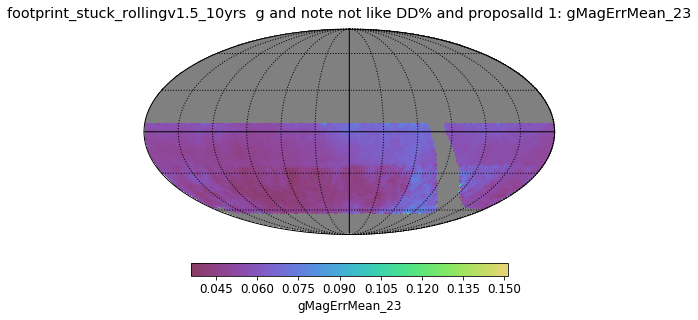

In [32]:
# Make sky plots
plotSky(bundleDicts, (2, 'gMagErrMean_23'))

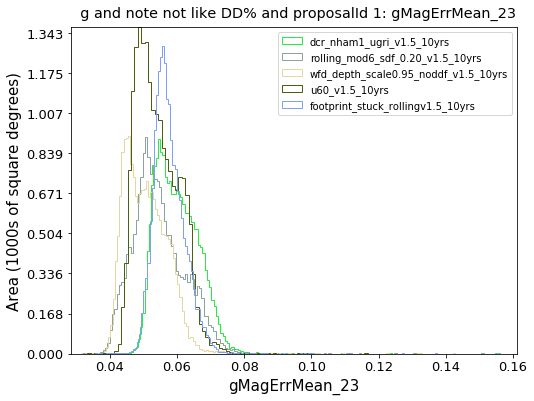

In [34]:
plotHist(bundleDicts, (2, 'gMagErrMean_23'))